In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 0
Title         = 'Synthetic Regression'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [5]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4955524627344029


MLPRegressor(random_state=RandomState(MT19937) at 0x1E1FF199840)

In [6]:
Reg_Data.Random_Forest()

0.5920381416390219


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1E1FF199840)

In [7]:
Reg_Data.GP()

-1.5229924767639078


GaussianProcessRegressor()

In [8]:
Reg_Data.L_Regression()

0.6775954711804781


LinearRegression()

In [9]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [10]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [11]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [12]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 5.51828766 19.07353952  7.86133168 19.86012933  6.90469303 11.411667
 -9.84234907  7.9533662 ]
Std 0:  [5.13992124 1.48571832 4.62746253 3.86790333 2.14509362 4.88715215
 3.87168546 3.75594994]


In [13]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics(feature_names = Reg_Data.get_features(),
                                 mode          = Reg_Data.get_mode(),
                                 X_train_std   = Reg_Data.get_X_train_std(),
                                 N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics(feature_names = Reg_Data.get_features(),
                                 mode          = Reg_Data.get_mode(),
                                 X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model(),
                         consistancy   = consistancy)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None,
                           model         = URM_Exp_2.get_exp_model())
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-11.76310191] [-1.17631019e+01  1.00000004e-05] [-11.76310191]
Acq_Data_nD
INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-51.11213492] [-5.11121349e+01  1.00000004e-05] [-51.11213492]
Acq_Data_nD
INSTANCE:  2
Acq_Data_nD
[-142.95821153] [-1.42958211e+02  1.00000004e-05] [-142.95821149]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-111.72319102] [-1.11723191e+02  1.00000004e-05] [-111.72319102]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  4
Acq_Data_nD
[-114.83188174] [-1.14831882e+02  1.00000004e-05] [-114.83188182]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  5
Acq_Data_nD
[-66.06631038] [-6.60663104e+01  1.00000004e-05] [-66.06631039]
Acq_Data_nD
INSTANCE:  6
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-15.49537865] [-1.54953787e+01  1.00000004e-05] [-15.49537866]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  7
Acq_Data_nD
[-169.12937684] [-1.69129377e+02  1.00000004e-05] [-169.12937682]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  8
Acq_Data_nD
[-167.25800429] [-1.67258004e+02  1.00000004e-05] [-167.25800434]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  9
Acq_Data_nD
[-113.11464228] [-1.13114642e+02  1.00000004e-05] [-113.11464229]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  10
Acq_Data_nD
[-186.91715523] [-1.86917155e+02  1.00000004e-05] [-186.91715532]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  11
Acq_Data_nD
[-96.05990419] [-9.60599042e+01  1.00000004e-05] [-96.05990422]
Acq_Data_nD
INSTANCE:  12
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-80.86761895] [-8.08676189e+01  1.00000004e-05] [-80.86761895]
Acq_Data_nD
INSTANCE:  13
Acq_Data_nD
[-82.23518817] [-8.22351870e+01  9.99990049e-06] [-82.2351871]
Acq_Data_nD
INSTANCE:  14
Acq_Data_nD
[-216.80401765] [-2.16804018e+02  1.00000004e-05] [-216.80401761]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  15
Acq_Data_nD
[-113.9397784] [-1.13939778e+02  1.00000004e-05] [-113.93977843]
Acq_Data_nD
INSTANCE:  16
Acq_Data_nD
[15.23744412] [1.52374441e+01 1.00000004e-05] [15.23744412]
Acq_Data_nD
INSTANCE:  17
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-203.52371542] [-2.03523722e+02  9.99988384e-06] [-203.52372229]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  18
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-136.05464272] [-1.36054643e+02  1.00000004e-05] [-136.05464276]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  19
Acq_Data_nD
[-105.84902909] [-1.05849029e+02  1.00000004e-05] [-105.84902911]
Acq_Data_nD
INSTANCE:  20
Acq_Data_nD
[-39.02904682] [-3.90290468e+01  1.00000004e-05] [-39.02904682]
Acq_Data_nD
INSTANCE:  21
Acq_Data_nD
[-186.99807092] [-1.86998071e+02  1.00000004e-05] [-186.9980709]
Acq_Data_nD
INSTANCE:  22
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-161.46694859] [-1.61466949e+02  1.00000004e-05] [-161.46694858]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  23
Acq_Data_nD
[27.16535621] [2.71653562e+01 1.00000004e-05] [27.16535621]
Acq_Data_nD
INSTANCE:  24
Acq_Data_nD
[-129.20027913] [-1.29200279e+02  1.00000004e-05] [-129.20027919]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  25
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[10.10140227] [1.01014023e+01 1.00000004e-05] [10.10140228]
Acq_Data_nD
INSTANCE:  26
Acq_Data_nD
[-98.92974357] [-9.89297436e+01  1.00000004e-05] [-98.92974358]
Acq_Data_nD
INSTANCE:  27
Acq_Data_nD
[-206.42256241] [-2.06422562e+02  1.00000004e-05] [-206.42256231]
Acq_Data_nD
INSTANCE:  28
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-25.57239067] [-2.55723907e+01  1.00000004e-05] [-25.57239068]
Acq_Data_nD
INSTANCE:  29
Acq_Data_nD
[-122.96609533] [-1.22966095e+02  1.00000004e-05] [-122.96609534]
Acq_Data_nD
INSTANCE:  30
Acq_Data_nD
[-112.16219681] [-1.12162197e+02  1.00000004e-05] [-112.16219685]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  31
Acq_Data_nD
[-198.65874701] [-1.98658747e+02  1.00000004e-05] [-198.65874702]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  32
Acq_Data_nD
[-90.08069883] [-9.00806988e+01  1.00000004e-05] [-90.08069882]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  33
Acq_Data_nD
[-170.20301788] [-1.70203018e+02  1.00000004e-05] [-170.20301786]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  34
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-60.78527259] [-6.07852726e+01  1.00000004e-05] [-60.78527258]
Acq_Data_nD
INSTANCE:  35
Acq_Data_nD
[-158.3948196] [-1.58394820e+02  1.00000004e-05] [-158.39481957]
Acq_Data_nD
INSTANCE:  36
Acq_Data_nD
[-142.39632166] [-1.42396322e+02  1.00000004e-05] [-142.3963217]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  37
Acq_Data_nD
[-123.53265691] [-1.23532657e+02  1.00000004e-05] [-123.53265693]
Acq_Data_nD
INSTANCE:  38
Acq_Data_nD
[-111.83957745] [-1.11839577e+02  1.00000004e-05] [-111.83957744]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  39
Acq_Data_nD
[-79.22146048] [-7.92214605e+01  1.00000004e-05] [-79.22146045]
Acq_Data_nD
INSTANCE:  40
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-105.87543603] [-1.05875436e+02  1.00000004e-05] [-105.87543604]
Acq_Data_nD
INSTANCE:  41
Acq_Data_nD
[-127.85799966] [-1.27858000e+02  1.00000004e-05] [-127.85799965]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  42
Acq_Data_nD
[-79.47513339] [-7.94751334e+01  1.00000004e-05] [-79.47513339]
Acq_Data_nD
INSTANCE:  43
Acq_Data_nD
[-157.05278286] [-1.57052783e+02  1.00000004e-05] [-157.05278285]
Acq_Data_nD
INSTANCE:  44
Acq_Data_nD
[-86.9353925] [-8.69353925e+01  1.00000004e-05] [-86.93539252]
Acq_Data_nD
INSTANCE:  45
Acq_Data_nD
[-71.7514762] [-7.17514762e+01  1.00000004e-05] [-71.7514762]
Acq_Data_nD
INSTANCE:  46
Acq_Data_nD
[-125.28788187] [-1.25287882e+02  1.00000004e-05] [-125.28788197]
Acq_Data_nD
INSTANCE:  47
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-131.11626534] [-1.31116265e+02  1.00000004e-05] [-131.11626532]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  48
Acq_Data_nD
[-154.18325359] [-1.54183254e+02  1.00000004e-05] [-154.18325356]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  49
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[-76.47189195] [-7.64718920e+01  1.00000004e-05] [-76.47189198]
Acq_Data_nD
INSTANCE:  50
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[32.04272147] [3.20427215e+01 1.00000004e-05] [32.04272147]
Acq_Data_nD
INSTANCE:  51
Acq_Data_nD
[-41.37473763] [-4.13747376e+01  1.00000004e-05] [-41.37473764]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  52
Acq_Data_nD
[-1.88638758] [-1.88638758e+00  1.00000004e-05] [-1.88638758]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  53
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-94.40465276] [-9.44046528e+01  1.00000004e-05] [-94.40465277]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  54
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-48.75588286] [-4.87558829e+01  1.00000004e-05] [-48.75588288]
Acq_Data_nD
INSTANCE:  55
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-126.50530107] [-1.26505301e+02  1.00000004e-05] [-126.50530128]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  56
Acq_Data_nD
[-236.63929468] [-2.36639295e+02  1.00000004e-05] [-236.63929485]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  57
Acq_Data_nD
[-130.4226827] [-1.30422683e+02  1.00000004e-05] [-130.42268268]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  58
Acq_Data_nD
[-51.03914397] [-5.10391440e+01  1.00000004e-05] [-51.03914398]
Acq_Data_nD
INSTANCE:  59
Acq_Data_nD
[-61.35268792] [-6.13526879e+01  1.00000004e-05] [-61.35268793]
Acq_Data_nD
INSTANCE:  60
Acq_Data_nD
[-137.59258579] [-1.37592586e+02  1.00000004e-05] [-137.59258575]
Acq_Data_nD
INSTANCE:  61
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-43.42860096] [-4.34286010e+01  1.00000004e-05] [-43.42860097]
Acq_Data_nD
INSTANCE:  62
Acq_Data_nD
[-113.99403618] [-1.13994036e+02  1.00000004e-05] [-113.99403615]
Acq_Data_nD
INSTANCE:  63
Acq_Data_nD
[-157.71108548] [-1.57711085e+02  1.00000004e-05] [-157.71108543]
Acq_Data_nD
INSTANCE:  64
Acq_Data_nD
[-41.23557081] [-4.12355708e+01  1.00000004e-05] [-41.2355708]
Acq_Data_nD
INSTANCE:  65
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-27.82792131] [-2.78279213e+01  1.00000004e-05] [-27.82792131]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  66
Acq_Data_nD
[-41.6210216] [-4.16210216e+01  1.00000004e-05] [-41.6210216]
Acq_Data_nD
INSTANCE:  67
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-141.38682383] [-1.41386824e+02  1.00000004e-05] [-141.38682383]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  68
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-209.30689875] [-2.09306899e+02  1.00000004e-05] [-209.30689875]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  69
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[-19.75705431] [-1.97570543e+01  1.00000004e-05] [-19.75705431]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Acq_Data_nD
INSTANCE:  70
Acq_Data_nD
[-129.6739749] [-1.29673975e+02  1.00000004e-05] [-129.67397492]
Acq_Data_nD
INSTANCE:  71
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-221.8048693] [-2.21804871e+02  9.99998931e-06] [-221.80487066]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  72
Acq_Data_nD
[-146.00667727] [-1.46006677e+02  1.00000004e-05] [-146.00667725]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  73
Acq_Data_nD
[-207.14735166] [-2.07147352e+02  1.00000004e-05] [-207.14735175]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  74
Acq_Data_nD
[-154.07084806] [-1.54070848e+02  1.00000004e-05] [-154.070848]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  75
Acq_Data_nD
[-92.24103373] [-9.22410338e+01  1.00000004e-05] [-92.24103377]
Acq_Data_nD
INSTANCE:  76
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[6.69996888] [6.69996888e+00 1.00000004e-05] [6.69996888]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  77
Acq_Data_nD
[-102.13203198] [-1.02132032e+02  1.00000004e-05] [-102.13203203]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  78
Acq_Data_nD
[-58.68487922] [-5.86848792e+01  1.00000004e-05] [-58.68487924]
Acq_Data_nD
INSTANCE:  79
Acq_Data_nD
[-104.63114424] [-1.04631144e+02  1.00000004e-05] [-104.63114423]
Acq_Data_nD
INSTANCE:  80
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-169.63104281] [-1.69631043e+02  1.00000004e-05] [-169.6310429]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  81
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[4.21966262] [4.21966264e+00 1.00000004e-05] [4.21966264]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  82
Acq_Data_nD
[-159.46914221] [-1.59469143e+02  1.00000004e-05] [-159.46914252]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  83
Acq_Data_nD
[-12.62764219] [-1.26276422e+01  1.00000004e-05] [-12.62764219]
Acq_Data_nD
INSTANCE:  84
Acq_Data_nD
[-130.72794058] [-1.30727941e+02  1.00000004e-05] [-130.72794059]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  85
Acq_Data_nD
[-103.80881178] [-1.03808812e+02  1.00000004e-05] [-103.80881178]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  86
Acq_Data_nD
[-138.83581671] [-1.38835817e+02  1.00000004e-05] [-138.83581676]
Acq_Data_nD
INSTANCE:  87
Acq_Data_nD
[-107.49232177] [-1.07492322e+02  1.00000004e-05] [-107.49232177]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  88
Acq_Data_nD
[-65.73239921] [-6.57323992e+01  9.99999486e-06] [-65.73239914]
Acq_Data_nD
INSTANCE:  89
Acq_Data_nD
[-185.40347456] [-1.85403475e+02  1.00000004e-05] [-185.40347454]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  90
Acq_Data_nD
[-139.78526333] [-1.39785263e+02  1.00000004e-05] [-139.78526338]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  91
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[-94.52763619] [-9.45276359e+01  9.99999486e-06] [-94.52763591]
Acq_Data_nD
INSTANCE:  92
Acq_Data_nD
[-133.34899849] [-1.33348999e+02  1.00000004e-05] [-133.34899852]
Acq_Data_nD
INSTANCE:  93
Acq_Data_nD
[-103.1140376] [-1.03114038e+02  1.00000004e-05] [-103.11403759]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  94
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-142.40353359] [-1.42403534e+02  1.00000004e-05] [-142.40353356]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  95
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-19.62496583] [-1.96249658e+01  1.00000004e-05] [-19.62496583]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  96
Acq_Data_nD
[-103.20053983] [-1.03200540e+02  1.00000004e-05] [-103.20053987]
Acq_Data_nD
INSTANCE:  97
Acq_Data_nD
[-131.956987] [-1.31956987e+02  1.00000004e-05] [-131.95698701]
Acq_Data_nD
INSTANCE:  98
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-199.20555298] [-1.99205552e+02  9.99998931e-06] [-199.20555249]
Acq_Data_nD
INSTANCE:  99
Acq_Data_nD
[-30.67615381] [-3.06761538e+01  1.00000004e-05] [-30.67615382]
Acq_Data_nD


In [14]:
import matplotlib.pyplot as plt


In [15]:
print(f_predict)
print(e_predict)


[-46.48806952]
[-4.64880695e+01  1.00000004e-05]


In [16]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


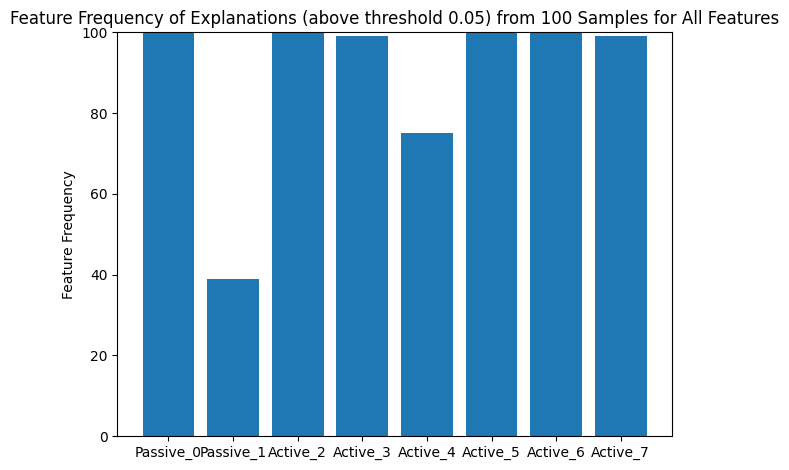

In [17]:
Reg_Stats.Frequency_Plot()


In [18]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           42.36067510454306  :  1133.4594409808328  :  134.52399594757088
y - exp(x):          42.36067503744494  :  1133.4594373824889  :  134.523995935704
BB(x) - exp(x):      1.2839443644718784e-07  :  4.880053980620311e-13  :  6.842427154651887e-06
Average exp(x) var:  9.999997915688204e-06


In [19]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.8043386243386245
Mean Jaccard Distance:    0.19566137566137567


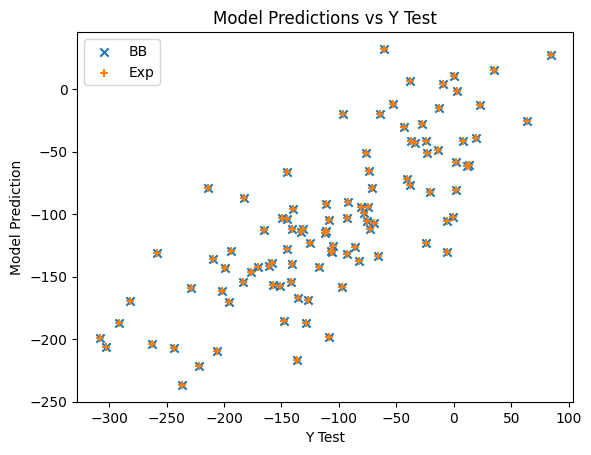

In [20]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (100, 8)


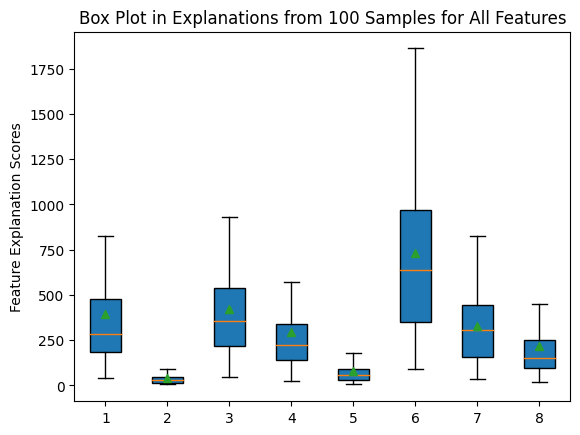

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [21]:
Reg_Stats.Box_Plot()


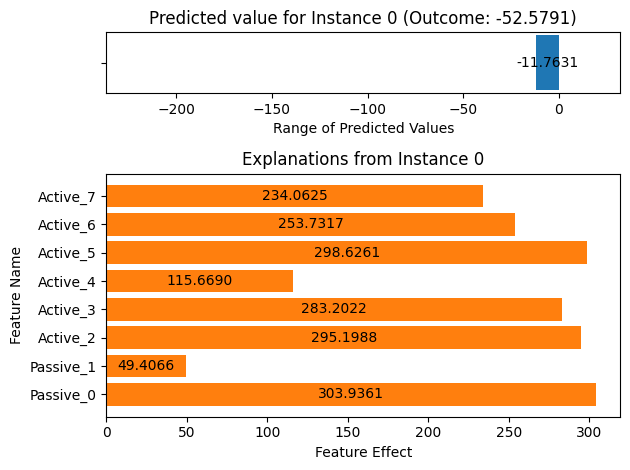

In [22]:
Reg_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[386.79331434  34.10506065 451.21537204  81.715216    99.56741152
 964.44052492 196.06118047  80.92976328]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[5.39282904 5.89897389 6.9691803  3.92761183 4.81254367 8.98597369
 5.05781327 4.66935159]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[18.36235704 22.9366201  53.82188283  6.44156606 17.23625943 91.55158411
 13.59770907 17.23505425]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[0.09470691 1.97290563 1.89013302 1.17480046 0.01705474 1.05527203
 1.6687921  0.1263351 ]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[3.16480937e-05 1.07116362e+00 1.08200380e-01 3.71770646e-03
 1.64811835e+00 4.18965182e+00 9.56083816e-01 2.30326669e-02]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-0.08869092 -7.18868444  7.1899042  -1.0611372   3.91294404 14.60508255
  0.53071142 -1.11781624]


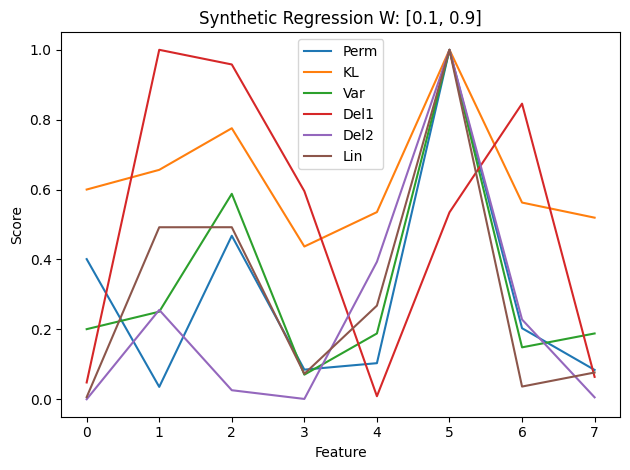

In [29]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.07987415e-02  9.95869263e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.62491442e-01 -1.81032829e-02  9.31811261e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

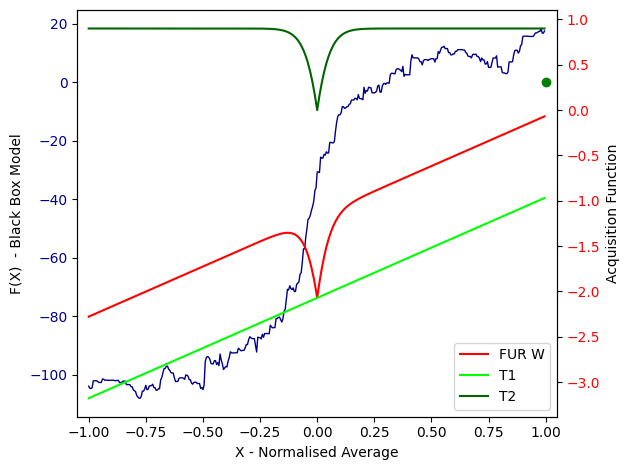

In [32]:
acq_data.plot_point(0)

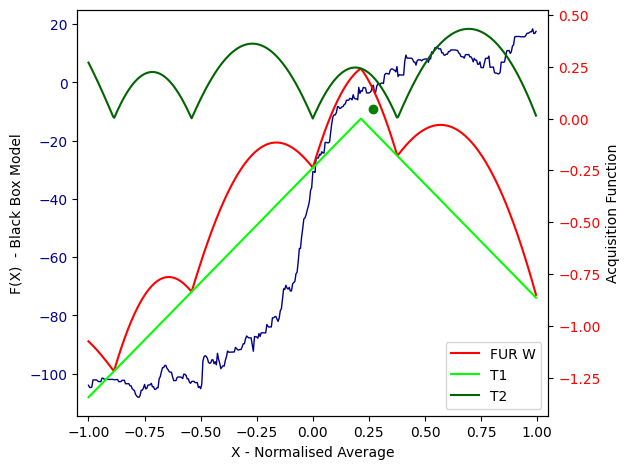

In [33]:
acq_data.plot_point(5)

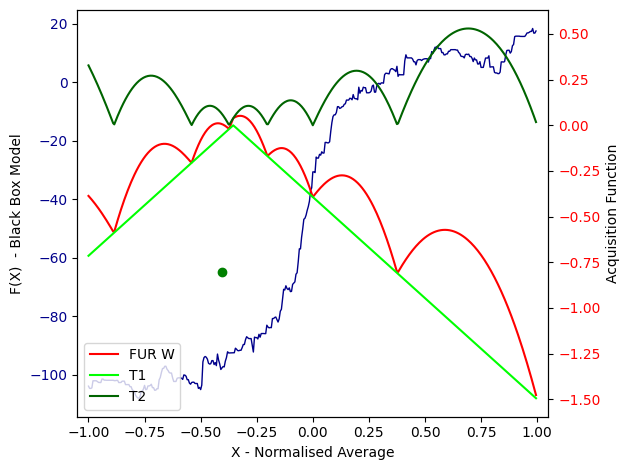

In [34]:
acq_data.plot_point(10)

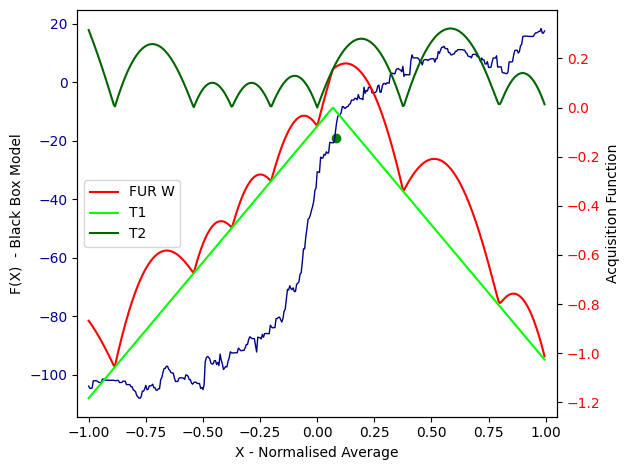

In [35]:
acq_data.plot_point(15)

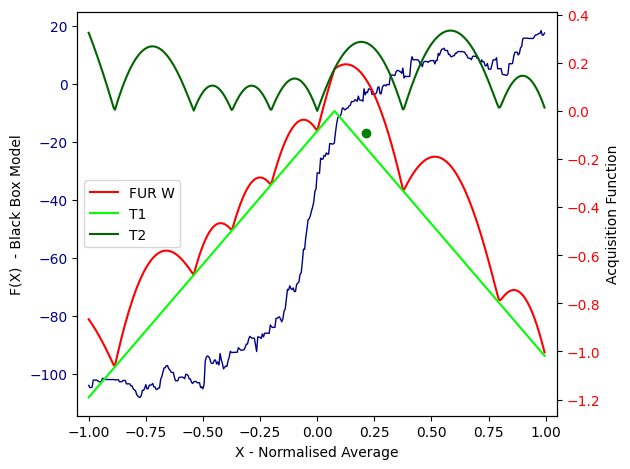

In [36]:
acq_data.plot_point(19)

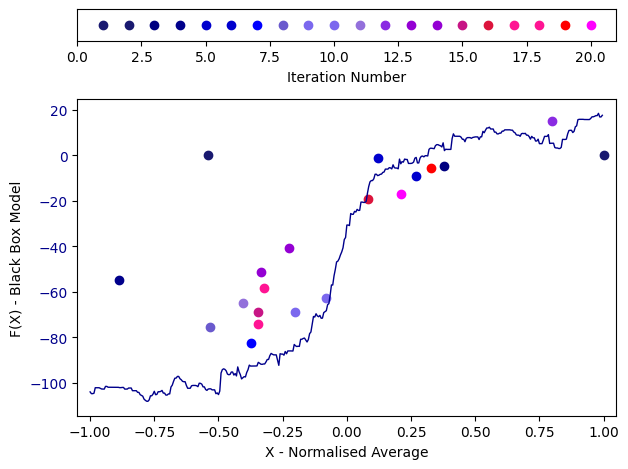

In [37]:
acq_data.plot_all()

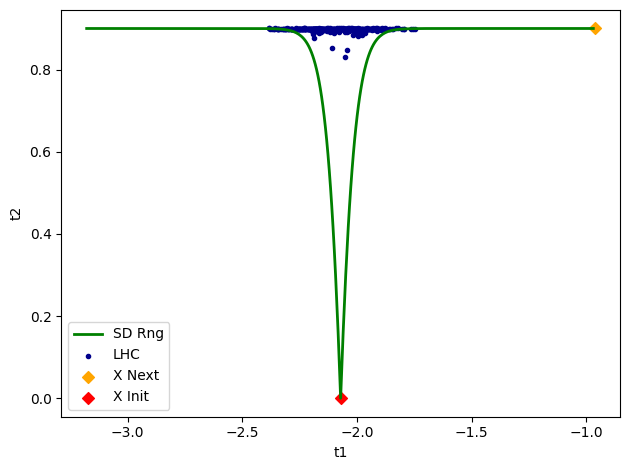

In [38]:
acq_data.plot_t1_t2(0)

In [39]:
#acq_data.plot_t1_t2(1)

In [40]:
#acq_data.plot_t1_t2(2)

In [41]:
#acq_data.plot_t1_t2(3)

In [42]:
#acq_data.plot_t1_t2(4)

In [43]:
#acq_data.plot_t1_t2(5)

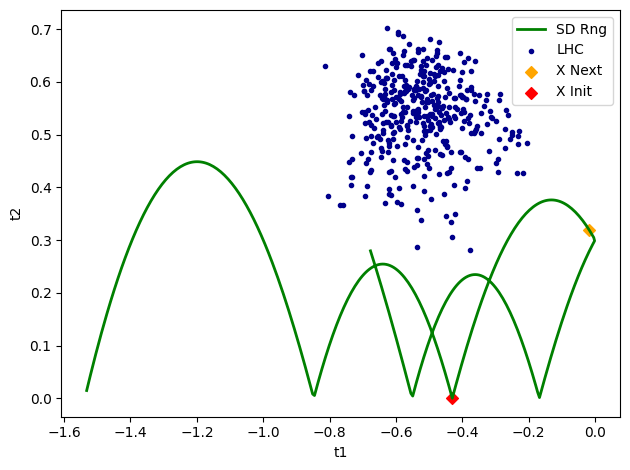

In [44]:
acq_data.plot_t1_t2(6)

In [45]:
#acq_data.plot_t1_t2(7)

In [46]:
#acq_data.plot_t1_t2(8)

In [47]:
#acq_data.plot_t1_t2(9)

In [48]:
#acq_data.plot_t1_t2(10)

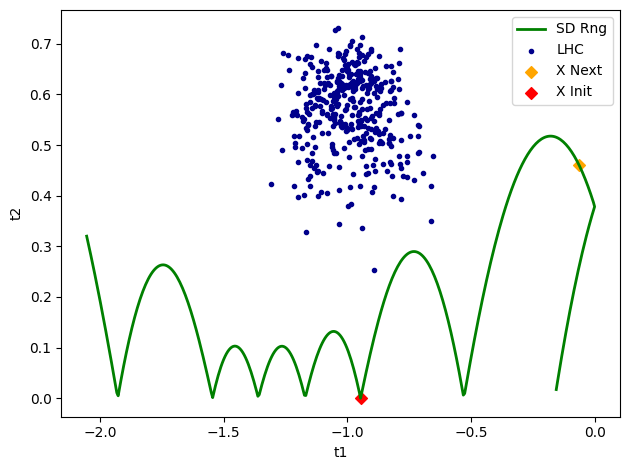

In [49]:
acq_data.plot_t1_t2(11)

In [50]:
#acq_data.plot_t1_t2(12)

In [51]:
#acq_data.plot_t1_t2(13)

In [52]:
#acq_data.plot_t1_t2(14)

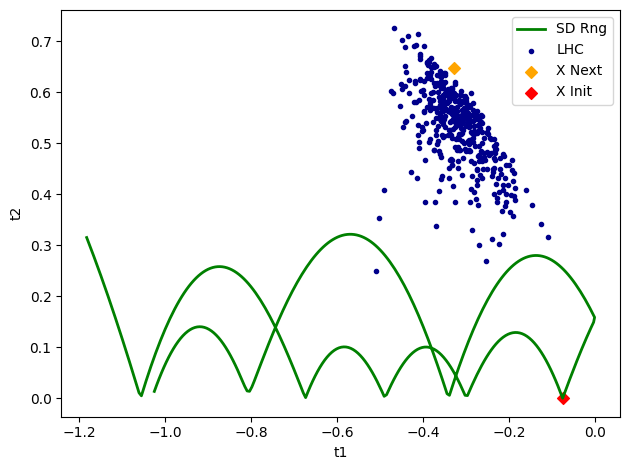

In [53]:
acq_data.plot_t1_t2(15)

In [54]:
#acq_data.plot_t1_t2(16)

In [55]:
#acq_data.plot_t1_t2(17)

In [56]:
#acq_data.plot_t1_t2(18)

In [57]:
#acq_data.plot_t1_t2(19)

In [58]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

Average, Var, and Max Differences:
y - BB(x):           42.36067510454306  :  1133.4594409808328  :  134.52399594757088
y - exp(x):          42.36067503744494  :  1133.4594373824889  :  134.523995935704
BB(x) - exp(x):      1.2839443644718784e-07  :  4.880053980620311e-13  :  6.842427154651887e-06
Average exp(x) var:  9.999997915688204e-06
Fidelity:  0.38566782389867665


In [59]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.6974660894660895
Mean Jaccard Distance:    0.30253391053391054
Jaccard:  0.6974660894660895


In [60]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Scores:  [394.89127213  41.35842307 422.32131762 294.79810277  79.5714039
 733.30144418 330.99219233 219.37191976]
Mean Coeffs:  [ 0.          0.          4.997531   -7.96373753 -4.05164407 10.00276031
  6.09545528 -1.99433476]
Coeff Ratio:  [ 0.          0.          0.01183348 -0.02701421 -0.05091834  0.01364072
  0.01841571 -0.00909111]


In [61]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

Delete 1 Variance:  [9.59282178e-32 1.87461095e-36 1.52990379e-21 6.01406734e-35
 5.42436854e-38 1.05878757e-15 1.26771149e-34 3.56631320e-36]


N_Points:  25


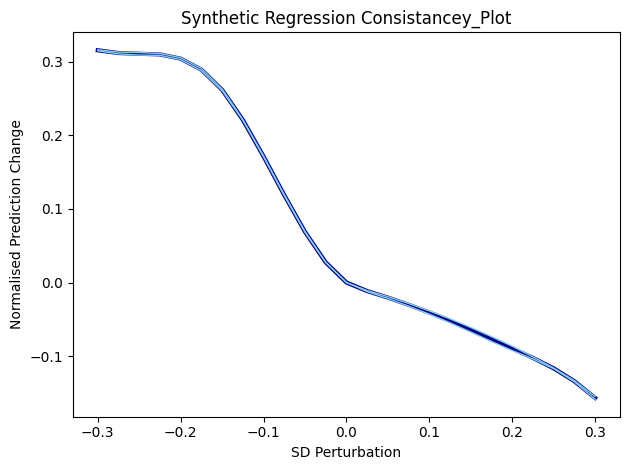

In [62]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [63]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

Score Diff Mean:  [1.32454931 0.15472962 1.31809892 0.94990778 0.29230448 2.22769805
 0.9427841  0.78992773]
Score Diff SD:    [1.57872093 0.29883451 1.38741354 1.31075089 0.46543548 2.577303
 1.23102542 0.92236235]


In [64]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

<class 'AttributeError'>: 'NoneType' object has no attribute 'reshape'